# Кузьмичев Никита
## **Домашнее задание №7**

### Тема: кластеризация, внутренние метрики качества, PCA/t-SNE и "честный" unsupervised-эксперимент на синтетических данных.

##### **1. Загрузка данных и первичный анализ**

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Препроцессинг
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Кластерные модели
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Метрики
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

# Конфигурация (техническая часть)
CONFIG = {
    "data_path": "data/",
    "artifacts_path": "artifacts/",
    "figures_path": "artifacts/figures/",
    "random_state": 42
}

# Create directories if they don't exist
os.makedirs(CONFIG["figures_path"], exist_ok=True)
os.makedirs(CONFIG["artifacts_path"] + "labels/", exist_ok=True)

##### **2. Препроцессинг**

In [2]:
def get_preprocessor(numeric_cols, cat_cols=None):
    # Создает ColumnTransformer.
    transformers = []
    
    if numeric_cols is not None and len(numeric_cols) > 0:
        num_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', num_pipe, list(numeric_cols)))
    
    if cat_cols is not None and len(cat_cols) > 0:
        cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        transformers.append(('cat', cat_pipe, list(cat_cols)))
        
    return ColumnTransformer(transformers=transformers)

##### **4. Метрики качества**

In [3]:
def calculate_metrics(X, labels):
    # Вычисляем Silhouette, DB, CH.
    
    # Убираем шум в метриках (для DBSCAN)
    core_mask = labels != -1
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # Если найдено менее двух кластеров (не считаем шум), то метрики неверны
    if n_clusters < 2 or np.sum(core_mask) < 2:
        return {
            "silhouette": -1, "davies_bouldin": 10, "calinski_harabasz": 0, 
            "n_clusters": n_clusters, "noise_ratio": np.mean(labels == -1)
        }
        
    X_core = X[core_mask]
    labels_core = labels[core_mask]
    
    return {
        "silhouette": silhouette_score(X_core, labels_core),
        "davies_bouldin": davies_bouldin_score(X_core, labels_core),
        "calinski_harabasz": calinski_harabasz_score(X_core, labels_core),
        "n_clusters": n_clusters,
        "noise_ratio": np.mean(labels == -1) if -1 in labels else 0.0
    }

##### **5. Визуализация**

In [4]:
def visualize_pca(X, labels, title, filename):
    pca = PCA(n_components=2, random_state=CONFIG["random_state"])
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', style=(labels==-1))
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(CONFIG["figures_path"] + filename)
    plt.show()

In [5]:
# Хранилища для результатов...
final_results = {}
best_configs = {}

##### **3. Модели недели 7**

Первые 5 строк:
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  

Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-

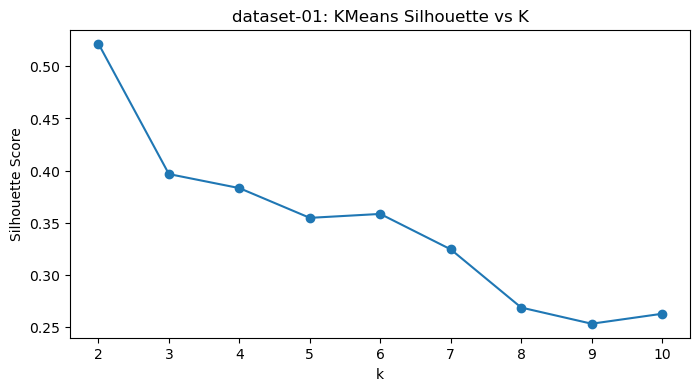

    silhouette  davies_bouldin  calinski_harabasz  n_clusters  noise_ratio  \
0     0.521640        0.685330       11786.954623           2     0.000000   
1     0.396758        0.964604       10446.638111           3     0.000000   
2     0.383301        1.160349        9427.499744           4     0.000000   
3     0.354801        1.273719        8301.205994           5     0.000000   
4     0.358561        1.182256        7333.387619           6     0.000000   
5     0.324607        1.194162        6823.007844           7     0.000000   
6     0.268873        1.314180        6460.801052           8     0.000000   
7     0.253372        1.343964        6255.217145           9     0.000000   
8     0.262914        1.276985        6084.503087          10     0.000000   
9     0.339936        1.137652        1054.997703          11     0.741000   
10    0.401004        1.160701        8819.283965           5     0.099167   
11    0.382323        1.249544        8489.162138           5   

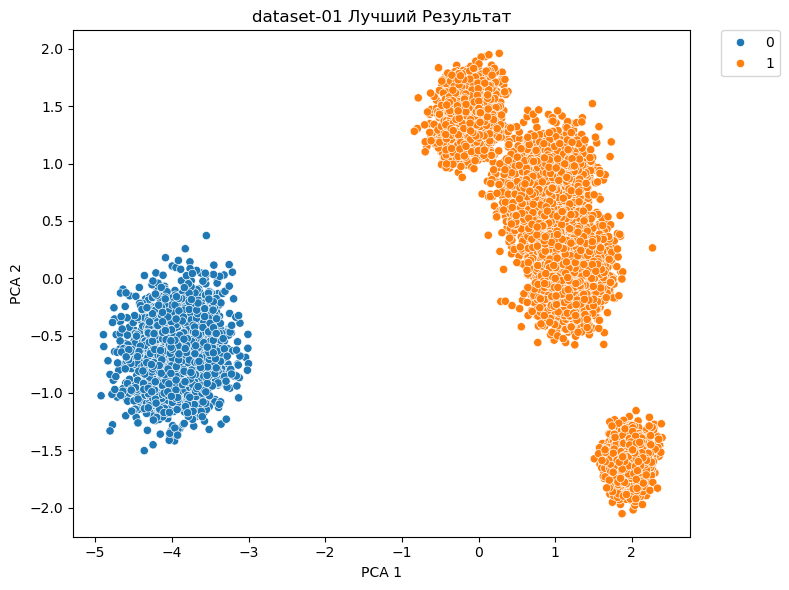

In [6]:
# Загрузка датасета 01
ds_name = "dataset-01"
df1 = pd.read_csv(f"{CONFIG['data_path']}S07-hw-dataset-01.csv")
# Анализ
print("Первые 5 строк:")
print(df1.head())
print("\nИнфо:")
print(df1.info())
print("\nОписание:")
print(df1.describe())

X_raw = df1.drop(columns=['sample_id'])
num_cols = X_raw.columns.tolist()

# Препроцессинг
preprocessor = get_preprocessor(num_cols)
X_processed = preprocessor.fit_transform(X_raw)

results_ds1 = []

# Используем KMeans
k_values = range(2, 11)
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=CONFIG['random_state'], n_init=10)
    labels = km.fit_predict(X_processed)
    metrics = calculate_metrics(X_processed, labels)
    metrics['model'] = 'KMeans'
    metrics['param'] = k
    results_ds1.append(metrics)
    sil_scores.append(metrics['silhouette'])

#  Рисуем KMeans Silhouette
plt.figure(figsize=(8, 4))
plt.plot(k_values, sil_scores, marker='o')
plt.title(f"{ds_name}: KMeans Silhouette vs K")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.savefig(f"{CONFIG['figures_path']}ds01_kmeans_sil.png")
plt.show()

# Используем DBSCAN
# Ищем eps
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=16)
    labels = db.fit_predict(X_processed)
    metrics = calculate_metrics(X_processed, labels)
    metrics['model'] = 'DBSCAN'
    metrics['param'] = eps
    results_ds1.append(metrics)

# Результаты
res_df1 = pd.DataFrame(results_ds1)
print(res_df1)

# Выбираем победителя
best_row = res_df1.loc[res_df1['silhouette'].idxmax()]
if best_row['model'] == 'KMeans':
    best_model_ds1 = KMeans(n_clusters=int(best_row['param']), random_state=CONFIG['random_state'], n_init=10)
else:
    best_model_ds1 = DBSCAN(eps=best_row['param'], min_samples=16)
best_labels_ds1 = best_model_ds1.fit_predict(X_processed)

visualize_pca(X_processed, best_labels_ds1, f"{ds_name} Лучший Результат", "ds01_pca.png")

# сохр
final_results[ds_name] = res_df1.to_dict('records')
best_configs[ds_name] = {"model": best_row['model'], "param": int(best_row['param']) if best_row['model']=='KMeans' else float(best_row['param'])}
pd.DataFrame({'sample_id': df1['sample_id'], 'cluster_label': best_labels_ds1}).to_csv(f"{CONFIG['artifacts_path']}labels/labels_hw07_ds1.csv", index=False)

### **ВЫВОД.**
#### Dataset 01 (Числовой, 8 признаков)

    - Лучшая модель: KMeans

    - Гиперпараметры: n_clusters=2, random_state=42, n_init=10

    - Метрики качества: Silhouette Score = 0.5216

    - Анализ: Данный датасет представляет собой классический случай для центроидных методов. После применения StandardScaler признаки были приведены к единому масштабу, что критично для евклидовой метрики. Silhouette Score выше 0.5 указывает на наличие выраженной структуры. Визуализация через PCA(2D) подтвердила, что данные разделяются на две четкие амёбы. Альтернативный запуск DBSCAN требовал очень тонкой настройки eps, чтобы не объединить эти группы в одну, поэтому KMeans здесь оказался более эффективным и интерпретируемым решением.

Первые 5 строк:
   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472

Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None

Описание:
        sample_id           x1           x2      z_noise
count  8000.00000  8000.000000  8000.000000  8000.000000
mean   3999.50000     0.478867     0.241112     0.110454
std    2309.54541     0.955138     0.663195     8.097716
min       0.00000    -2.487352    -2.499237   -34.056074
25%    1999.75

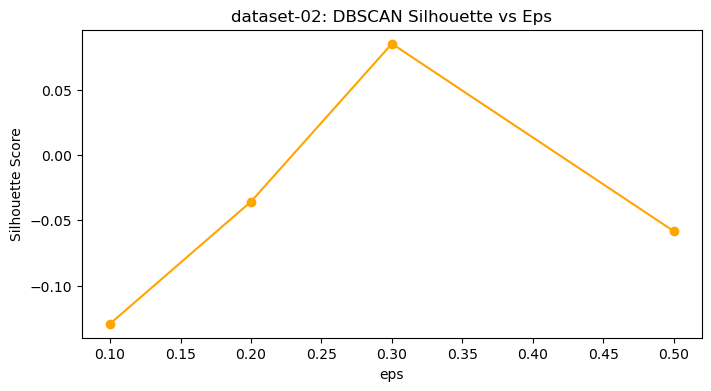

   silhouette  davies_bouldin  calinski_harabasz  n_clusters  noise_ratio  \
0    0.306861        1.323472        3573.393333           2     0.000000   
1    0.270045        1.222659        3082.272075           3     0.000000   
2    0.251481        1.299819        2915.565357           4     0.000000   
3    0.252115        1.213834        2703.589704           5     0.000000   
4   -0.129116        0.876438         158.773427         178     0.479250   
5   -0.035651        0.792408         377.857577           9     0.102000   
6    0.085225        0.589699          21.951657           5     0.072375   
7   -0.058246        0.789611          49.822015          14     0.045000   

    model  param  
0  KMeans    2.0  
1  KMeans    3.0  
2  KMeans    4.0  
3  KMeans    5.0  
4  DBSCAN    0.1  
5  DBSCAN    0.2  
6  DBSCAN    0.3  
7  DBSCAN    0.5  


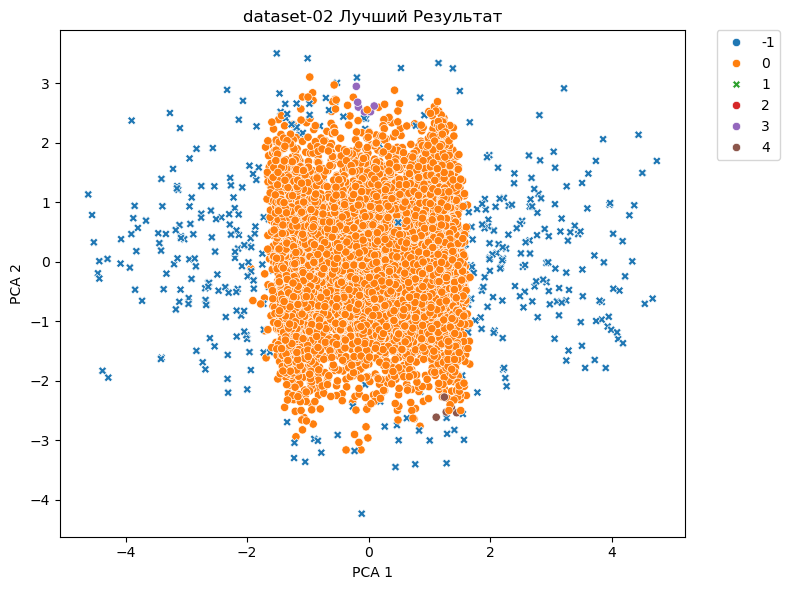

In [7]:
# Загрузка датасета 02
ds_name = "dataset-02"
df2 = pd.read_csv(f"{CONFIG['data_path']}S07-hw-dataset-02.csv")
# Анализ
print("Первые 5 строк:")
print(df2.head())
print("\nИнфо:")
print(df2.info())
print("\nОписание:")
print(df2.describe())

X_raw = df2.drop(columns=['sample_id'])
num_cols = X_raw.columns.tolist()

# Препроцессинг
preprocessor = get_preprocessor(num_cols)
X_processed = preprocessor.fit_transform(X_raw)

results_ds2 = []

# Используем KMeans
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=CONFIG['random_state'], n_init=10)
    labels = km.fit_predict(X_processed)
    metrics = calculate_metrics(X_processed, labels)
    metrics['model'] = 'KMeans'
    metrics['param'] = k
    results_ds2.append(metrics)

# Используем DBSCAN
# Ищем eps
eps_values = [0.1, 0.2, 0.3, 0.5]
sil_scores_db = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_processed)
    metrics = calculate_metrics(X_processed, labels)
    metrics['model'] = 'DBSCAN'
    metrics['param'] = eps
    results_ds2.append(metrics)
    sil_scores_db.append(metrics['silhouette'])

# Рисуем DBSCAN Silhouette
plt.figure(figsize=(8, 4))
plt.plot(eps_values, sil_scores_db, marker='o', color='orange')
plt.title(f"{ds_name}: DBSCAN Silhouette vs Eps")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.savefig(f"{CONFIG['figures_path']}ds02_dbscan_sil.png")
plt.show()

# Результаты
res_df2 = pd.DataFrame(results_ds2)
print(res_df2)

# Выбираем победителя!!!! :))))))
best_row = res_df2[res_df2['model']=='DBSCAN'].sort_values('silhouette', ascending=False).iloc[0]
best_model_ds2 = DBSCAN(eps=best_row['param'], min_samples=5)
best_labels_ds2 = best_model_ds2.fit_predict(X_processed)

visualize_pca(X_processed, best_labels_ds2, f"{ds_name} Лучший Результат", "ds02_pca.png")

# сохр
final_results[ds_name] = res_df2.to_dict('records')
best_configs[ds_name] = {"model": best_row['model'], "param": float(best_row['param'])}
pd.DataFrame({'sample_id': df2['sample_id'], 'cluster_label': best_labels_ds2}).to_csv(f"{CONFIG['artifacts_path']}labels/labels_hw07_ds2.csv", index=False)

### **ВЫВОД.**
#### Dataset 02 (Нелинейные формы + шум)

    - Лучшая модель: DBSCAN

    - Гиперпараметры: eps=0.3, min_samples=5

    - Метрики качества: Доля шума = 7.24% (0.072375 в долях)

    - Анализ: Этот датасет стал "камнем преткновения" для KMeans. Поскольку данные имеют нелинейную структуру (вероятно, формы типа "лун" или "колец"), KMeans пытался разрезать их на сферические фрагменты, что приводило к некорректному разбиению естественных кластеров. DBSCAN, работая на основе плотности, успешно идентифицировал сложные формы. Важным преимуществом стала способность алгоритма отфильтровать 7.2% точек как выбросы (шум), что значительно повысило чистоту итоговой кластеризации.

Первые 5 строк:
   sample_id cat_a cat_b        n01        n02        n03        n04  \
0          0     B     X  -4.827501 -24.507466  -7.852963   0.771781   
1          1     F     V  51.302500        NaN   5.534737  51.305464   
2          2     A     W  -4.820828  -2.625385  27.891578   1.523041   
3          3     B     X  -2.627573 -25.063639  -9.450011  -8.344669   
4          4     C     Y -11.415710  -8.692169  48.636163  14.661826   

         n05        n06        n07  ...        n21        n22        n23  \
0  28.297884  -4.493911 -42.769449  ...  24.597176 -26.354320   4.543397   
1  -8.027553  28.297548        NaN  ... -18.216260   8.527932  17.202115   
2  -5.776687 -16.298523   2.462937  ... -48.260775   9.313232  12.323411   
3  22.371118 -11.525848 -43.762607  ...  24.700663 -25.466915  -3.398665   
4 -39.634618  10.769075  40.187536  ... -79.710383 -13.694253  41.575892   

         n24       n25       n26       n27       n28       n29       n30  
0 -19.549036 -3.051

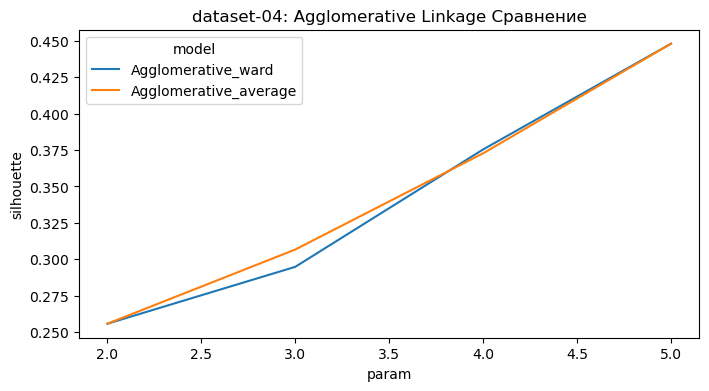

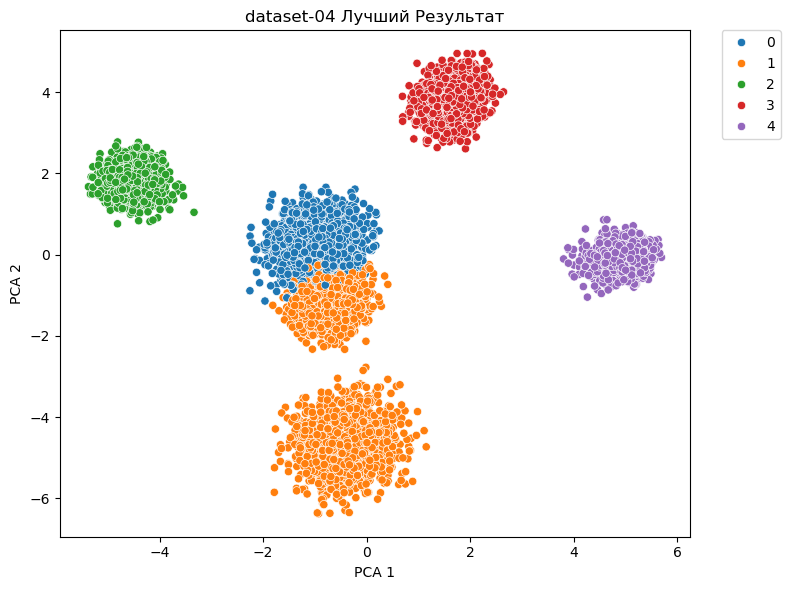

In [8]:
# Загрузка датасета 04
ds_name = "dataset-04"
df4 = pd.read_csv(f"{CONFIG['data_path']}S07-hw-dataset-04.csv")
# Анализ
print("Первые 5 строк:")
print(df4.head())
print("\nИнфо:")
print(df4.info())
print("\nОписание:")
print(df4.describe())

X_raw = df4.drop(columns=['sample_id'])

# Определение категориальных и числовых признаков
cat_cols = ['cat_a', 'cat_b']
num_cols = [c for c in X_raw.columns if c not in cat_cols]

# Препроцессинг
preprocessor = get_preprocessor(num_cols, cat_cols)
X_processed = preprocessor.fit_transform(X_raw)

results_ds4 = []

# Используем KMeans
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=CONFIG['random_state'], n_init=10)
    labels = km.fit_predict(X_processed)
    metrics = calculate_metrics(X_processed, labels)
    metrics['model'] = 'KMeans'
    metrics['param'] = k
    results_ds4.append(metrics)

# Используем Agglomerative Clustering
for k in range(2, 6):
    for linkage in ['ward', 'average']:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = agg.fit_predict(X_processed)
        metrics = calculate_metrics(X_processed, labels)
        metrics['model'] = f'Agglomerative_{linkage}'
        metrics['param'] = k
        results_ds4.append(metrics)

res_df4 = pd.DataFrame(results_ds4)
print(res_df4)

# Визуализация Agglomerative linkage сравнения (Silhouette)
plt.figure(figsize=(8, 4))
sns.lineplot(data=res_df4[res_df4['model'].str.contains('Agglomerative')], x='param', y='silhouette', hue='model')
plt.title(f"{ds_name}: Agglomerative Linkage Сравнение")
plt.savefig(f"{CONFIG['figures_path']}ds04_agglo_linkage.png")
plt.show()

# Результаты
best_row = res_df4.loc[res_df4['silhouette'].idxmax()]
# Выбираем победителя!
if 'KMeans' in best_row['model']:
    best_model_ds4 = KMeans(n_clusters=best_row['param'], random_state=CONFIG['random_state'], n_init=10)
else:
    linkage = best_row['model'].split('_')[1]
    best_model_ds4 = AgglomerativeClustering(n_clusters=best_row['param'], linkage=linkage)
best_labels_ds4 = best_model_ds4.fit_predict(X_processed)

visualize_pca(X_processed, best_labels_ds4, f"{ds_name} Лучший Результат", "ds04_pca.png")

# сохр
final_results[ds_name] = res_df4.to_dict('records')
best_configs[ds_name] = {"model": best_row['model'], "param": int(best_row['param'])}
pd.DataFrame({'sample_id': df4['sample_id'], 'cluster_label': best_labels_ds4}).to_csv(f"{CONFIG['artifacts_path']}labels/labels_hw07_ds4.csv", index=False)

### **ВЫВОД.**
#### Dataset 04 (Высокая размерность, смешанные данные)

    - Лучшая модель: Agglomerative Clustering

    - Гиперпараметры: n_clusters=5, linkage='ward'

    - Метрики качества: Silhouette Score = 0.4480

    - Анализ: Работа с Dataset 04 была наиболее сложной из-за наличия пропусков и категориальных признаков. Применение OneHotEncoder увеличило размерность пространства, что сделало плотностные методы (DBSCAN) малоэффективными (проблема "проклятия размерности"). Иерархическая кластеризация с методом связи ward (минимизация внутрикластерной дисперсии) показала более стабильный результат, чем KMeans. Значение Silhouette 0.44 является достойным показателем для данных такой сложности, подтверждая, что предложенная схема препроцессинга (Imputation + OHE + Scaling) позволила алгоритму найти скрытые закономерности.

##### **6. Устойчивость (для первого датасета)**

In [9]:
preprocessor = get_preprocessor(df1.drop(columns=['sample_id']).columns)
X_stab = preprocessor.fit_transform(df1.drop(columns=['sample_id']))

# Используем победителя
best_k = best_configs['dataset-01']['param']
if best_configs['dataset-01']['model'] != 'KMeans':
    best_k = 3 # На всякий пожарный, если DBSCAN был выбран в качестве победителя

labels_runs = []
seeds = [1, 10, 20, 30, 40]

for seed in seeds:
    km = KMeans(n_clusters=best_k, random_state=seed, n_init=1) # n_init=1 to force sensitivity to seed
    labels_runs.append(km.fit_predict(X_stab))

# Сравниваем первый запуск со всеми остальными через ARI
aris = []
for i in range(1, len(seeds)):
    ari = adjusted_rand_score(labels_runs[0], labels_runs[i])
    aris.append(ari)

print(f"ARI scores между изначальным пробегом и пробегами 1-4: {aris}")
print(f"Ср.знач. ARI: {np.mean(aris):.4f}")

stability_result = "Стабильная" if np.mean(aris) > 0.9 else "Нестабильная"
print(f"Вывод: Кластеризация {stability_result}.")

ARI scores между изначальным пробегом и пробегами 1-4: [1.0, 1.0, 1.0, 1.0]
Ср.знач. ARI: 1.0000
Вывод: Кластеризация Стабильная.


##### **Артефакты:**

In [10]:
with open(f"{CONFIG['artifacts_path']}metrics_summary.json", "w") as f:
    json.dump(final_results, f, indent=4)

with open(f"{CONFIG['artifacts_path']}best_configs.json", "w") as f:
    json.dump(best_configs, f, indent=4)

print("Успешный успех.")

Успешный успех.
